<a href="https://colab.research.google.com/github/Tapanmittal13/Data_Science/blob/master/Assignment_11_Tapan_6A_M6_Amit_Doda_cutout_LRfinder_SGDmomentum_Gradcam_25misclassified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import backend as K
import time
import keras
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
def show_examples(X,y,classes):
    rows = int(np.ceil(len(X)/5))
    if X.shape[1] > 64:
        multiplier = 2
    else:
        multiplier = 1
    fig = plt.figure(figsize=(10*multiplier, rows*2*multiplier))
    for idx in np.arange(len(X)):
        img = X[idx]
        assert (len(img.shape)==3 and img.shape[2] in [1,3,4]) or len(img.shape)==2
        ax = fig.add_subplot(rows, 5, idx + 1, xticks=[], yticks=[])
        cmap = None
        if (len(img.shape)==3 and img.shape[2]==1) or len(img.shape)==2:
            cmap="binary"
        if len(img.shape)==3 and img.shape[2]==1:
            img = img.reshape((img.shape[0],img.shape[1]))
        ax.imshow(img,cmap=cmap)
        ax.set_title(classes[np.argmax(y[idx])])
    plt.show()

In [0]:
from sklearn.utils import shuffle

def get_cifar10_data(preprocess=False):
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    num_classes = len(np.unique(y_train))
    #X_train, y_train = shuffle(X_train, y_train)
    #X_test, y_test = shuffle(X_test, y_test)

    if preprocess:
        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')
        X_train /= 255
        X_test /= 255

    Y_train = np_utils.to_categorical(y_train, num_classes)
    Y_test = np_utils.to_categorical(y_test, num_classes)
    return X_train, Y_train, X_test, Y_test

In [0]:
def min_max_scale(X):
  return (X - np.min(X))/(np.max(X)-np.min(X))

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# load dataset
from keras.datasets import cifar10
trainX, trainy, testX, testy = get_cifar10_data(preprocess=False)

classes=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (trainX.mean(), trainX.std(), testX.mean(), testX.std()))

# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate the mean on the training dataset
datagen.fit(trainX)

# demonstrate effect on entire training dataset
iterator = datagen.flow(trainX, trainy, batch_size=len(trainX),shuffle=False)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

Statistics train=120.708 (64.150), test=121.529 (64.061)
(50000, 32, 32, 3) -1.6605131e-06 1.0000001


In [0]:
iterator1 = datagen.flow(testX, testy, batch_size=len(testX), shuffle=False)
batch_testX, batch_testy = iterator1.next()  #only Image Normalization is applied to test dataset and same is used for accuracy calculation

##Cutout

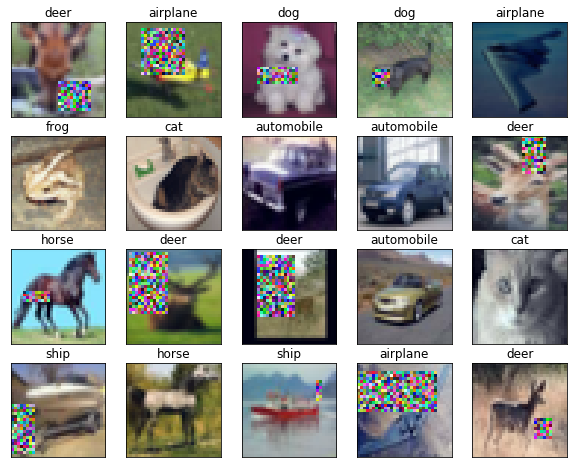

In [0]:
batchX = min_max_scale(batchX)
batch_testX=min_max_scale(batch_testX) #required for test data as well otherwise VA will be around 37%

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))
bs=128

iterator=datagen.flow(batchX, batchy, batch_size = bs)
X_train,Y_train=iterator.next()
show_examples(X_train[10:30], Y_train[10:30], classes)

In [0]:
# Define the model
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), border_mode='same',kernel_regularizer=regularizers.l2(0.0001),name='conv2D_1', input_shape=(32, 32, 3)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(64, (3, 3),kernel_regularizer=regularizers.l2(0.0001),name='conv2D_2',border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(32, (1, 1),name='conv2D_3'))


  model.add(Conv2D(64, (3, 3),kernel_regularizer=regularizers.l2(0.0001),name='conv2D_4',border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(128, (3, 3),kernel_regularizer=regularizers.l2(0.0001),name='conv2D_5',border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(32, (1, 1),name='conv2D_6'))


  model.add(Conv2D(128, (3, 3),kernel_regularizer=regularizers.l2(0.0001),name='conv2D_7', border_mode="same"))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(256, (3, 3),kernel_regularizer=regularizers.l2(0.0001),name='conv2D_8', border_mode="same"))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(10, (1, 1),name='conv2D_9'))

  model.add(AveragePooling2D(pool_size = (4,4)))
  model.add(Flatten())


  model.add(Activation('softmax'))
  return model

In [0]:
model=define_model()
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., name="conv2D_1", input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., name="conv2D_2", padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., name="conv2D_4", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., name="conv2D_5", padding="same")`
/usr/local/lib/python3.6/dist-p

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_43 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_44 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 64)        0         
__________

### Total params: 455,370

##LR Finder

In [0]:
from keras.callbacks import Callback

class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

In [0]:
from keras import optimizers

# Compile the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(trainX.shape[0]/bs))

model.fit_generator(iterator,steps_per_epoch = trainX.shape[0]/bs, epochs = 1, callbacks=[lr_finder],verbose=1)

Epoch 1/1
391/390 [==============================] - 13s 33ms/step - loss: 3.1152 - acc: 0.1816


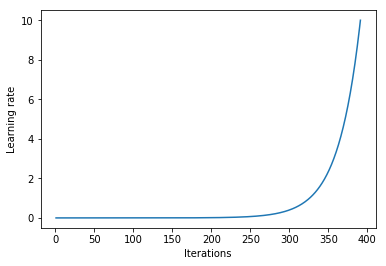

In [0]:
lr_finder.plot_lr()

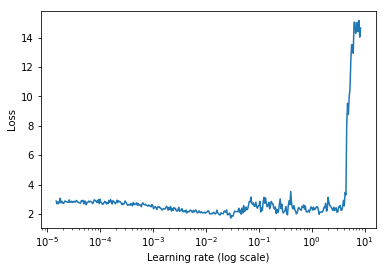

In [0]:
lr_finder.plot()

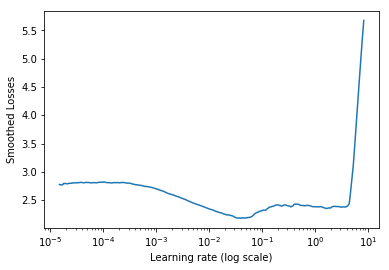

In [0]:
lr_finder.plot_smoothed_loss()

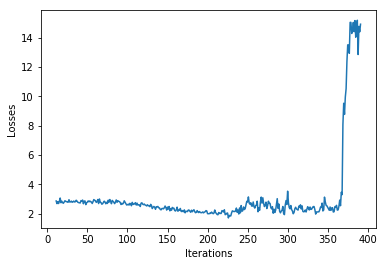

In [0]:
lr_finder.plot_loss()

In [0]:
lr_value=0.03

##Training

In [0]:
model=define_model()

from keras.callbacks import ModelCheckpoint

checkpoint=ModelCheckpoint(filepath='../content/gdrive/My Drive/EVA/Project_11/model_session11.h5', monitor='val_acc', mode='auto', verbose = 0, save_best_only=True)

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

sgd=optimizers.SGD(lr=lr_value,decay=0,momentum=0.9,nesterov=False) #enter lr finder learning rate here

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(iterator,
                                 steps_per_epoch = trainX.shape[0]/bs, epochs = 100, 
                                 validation_data = (batch_testX, batch_testy), callbacks=[checkpoint],verbose=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., name="conv2D_1", input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., name="conv2D_2", padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., name="conv2D_4", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., name="conv2D_5", padding="same")`
/usr/local/lib/python3.6/dist-p

Model took 1184.72 seconds to train


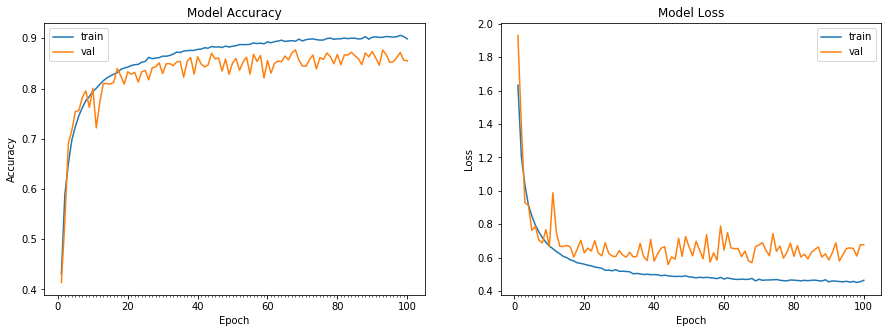

Accuracy on test data is: 85.51


In [0]:
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(batch_testX, batch_testy, model))

##Grad CAM with Misclassified Images

In [0]:
model=keras.models.load_model('../content/gdrive/My Drive/EVA/Project_11/model_session11.h5')

In [0]:
score = model.evaluate(batch_testX, batch_testy, batch_size=128)
print (score[1])

10000/10000 [==============================] - 2s 220us/step
0.8768


In [0]:

# images = []
# labels = []
# predictions = []
# examples=25

# while len(images) < examples:
  
#   Y_pred=model.predict(batch_testX)
  
#   batch_testX, batch_testy = iterator1.next()
#   batch_testX=min_max_scale(batch_testX)
  
#   testXX=batch_testX
  
  
#   Y = np.argmax(batch_testy, axis=1)
#   Y_pred = np.argmax(Y_pred, axis=1)
  
#   misclassified =  Y_pred !=  Y
#   #print(len(misclassified))
#   testXX = testXX[misclassified]
#   Y = Y[misclassified]
#   Y_pred = Y_pred[misclassified]
#   images.extend(testXX)
#   labels.extend(Y)
#   predictions.extend(Y_pred)

# print(len(images))
# print(len(labels))
# print(len(predictions))

In [0]:
import matplotlib.gridspec as gridspec
import cv2
def gradcam(model,layer,img,normalized_input=True,show=False):
  if not normalized_input:
    img = img/255
  x = np.expand_dims(img, axis=0)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer)
  layer_out_channels = last_conv_layer.output_shape[-1]
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(layer_out_channels):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
  heatmap = heatmap/255
  
#   superimposed_img = cv2.addWeighted(img, 0.75, heatmap, 0.25, 0)
  superimposed_img = 0.7*(img) + 0.3*heatmap
  superimposed_img = superimposed_img
  if show:
    plt.imshow(img)
    plt.show()
    plt.imshow(heatmap)
    plt.show()
    plt.imshow(superimposed_img)
    plt.show()
  return img,superimposed_img

# _ = gradcam(model,"output_transition",X_e[0],show=True)

def show_examples_with_gradcam(model,layer,X,Y,Y_pred,classes,image_size_multiplier=2):
  Y = np.argmax(Y, axis=1)  if type(Y[0]) == list or type(Y[0]) == np.ndarray else Y
  Y_pred=np.argmax(Y_pred, axis=1)  if type(Y_pred[0]) == list or type(Y_pred[0]) == np.ndarray else Y_pred
  columns = 5
  rows = int(np.ceil(len(X) / columns))
  
  fig_height = rows * image_size_multiplier * 2
  fig_width = columns * image_size_multiplier
  fig = plt.figure(figsize=(fig_width, fig_height))
  outer = gridspec.GridSpec(rows, columns, wspace=0.0, hspace=0.2)
  for i in range(rows*columns):
    if i>=len(X):
      break
    x = X[i]
    y = Y[i]
    y_p=Y_pred[i]
    pred=classes[y_p]
    actual=classes[y]
    label = actual.split(' ', 1)[0]
    img,superimposed_img = gradcam(model,layer,x,show=False)
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i], wspace=0.0, hspace=0.05)
    imgs = [img,superimposed_img]
    titles= [("Actual:" + label+ " Pred:" + pred).replace(' ', '\n')]
    
    for j in range(2):
        ax = plt.Subplot(fig, inner[j])
        ax.imshow(imgs[j])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles.pop() if len(titles) > 0 else "")
        fig.add_subplot(ax)
  
  fig.show()

In [0]:
#Misclassified images
import random

id=[]

Y = np.argmax(batch_testy, axis=1)

Y_pred=model.predict(batch_testX)
Y_pred=np.argmax(Y_pred, axis=1)

for i in range (len(batch_testX)):
  if(Y_pred[i]!=Y[i]):
    id.append(i)

print("No of Missclassified Images:",len(id))
random_list=random.sample(id,25)
print(random_list)

No of Missclassified Images: 1232
[9609, 5229, 7400, 1685, 6532, 5455, 9301, 7519, 9933, 3408, 4935, 7906, 734, 8197, 3962, 3799, 2494, 2535, 1126, 5752, 1501, 3258, 6916, 9982, 430]


In [0]:
images=[]
labels=[]
predictions=[]

for i in random_list:
  
  images.append(batch_testX[i])
  labels.append(batch_testy[i])
  predictions.append(Y_pred[i])
  

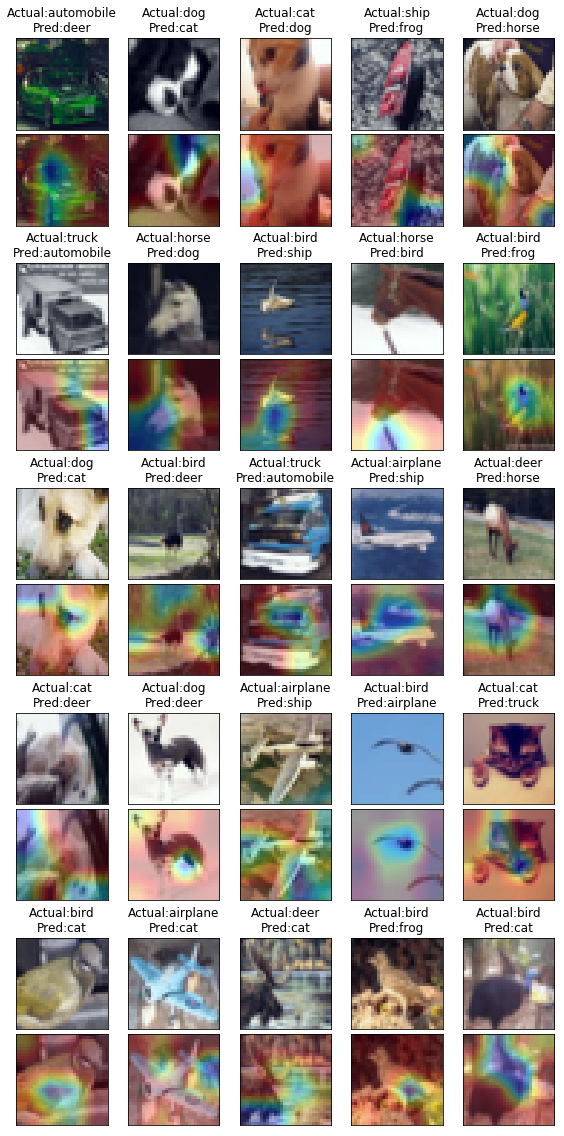

In [0]:
show_examples_with_gradcam(model,"conv2D_9",images[:25],labels[:25],predictions[:25],classes,image_size_multiplier=2)